In [1]:
#Import necessary Libraries
import numpy as np
import scipy
from scipy.optimize import minimize
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

### Question 5

In [2]:
def f_objective(theta, X, y, l2_param):
    '''
    Args:
        theta: 1D numpy array of size num_features
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        l2_param: regularization parameter

    Returns:
        objective: scalar value of objective function
    '''
    #Helper variable for ERM Summation
    objective = 0
    #Iterate over data points
    for i in range(len(y)):
        #Calculate 1+e^margin
        m = -y[i]*theta@X[i,:]
        #Add the margin exponentiation to the ERM summation
        objective += np.logaddexp(0, m)
    #Calculate the regularization penalty
    l2_penalty = l2_param* (theta@theta)
    return (objective / len(y))+ l2_penalty

### Question 6

In [3]:
def fit_logistic_reg(X, y, objective_function, l2_param):
    '''
    Args:
        X: 2D numpy array of size (num_instances, num_features)
        y: 1D numpy array of size num_instances
        objective_function: function returning the value of the objective
        l2_param: regularization parameter
        
    Returns:
        optimal_theta: 1D numpy array of size num_features
    '''      
    starting_theta = np.ones(X.shape[1])
    passing_func = partial(objective_function,X=X,y=y,l2_param=l2_param)
    optimal_theta = minimize(passing_func,starting_theta).x
    return optimal_theta

In [16]:
#Load Data, then Clean it
X_train, X_val = pd.read_csv('X_train.txt',header=None), pd.read_csv('X_val.txt',header=None)
y_train, y_val = pd.read_csv('y_train.txt',header=None), pd.read_csv('y_val.txt',header=None)  
#Fix y_train / val labels to -1 rather than 0 
y_train[y_train==0], y_val[y_val==0] = -1, -1
#Standardize via Z-Scores, Add Bias Column
X_val = (X_val - X_train.mean() )/ X_train.std()
X_train = (X_train - X_train.mean() )/ X_train.std()
#X_val = (X_val - X_val.mean())/ X_val.std()
X_train['Bias'] = 1
X_val['Bias'] = 1

#Transform DataFrames to numpy ararys
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

### Problem 7

In [17]:
def NLL(X,y,theta):
    nll = 0
    for i in range(len(y)):
        m = -y[i]*theta@X[i,:]
        nll += np.logaddexp(0,m)
    return(nll)

In [18]:
#lambda_list = np.linspace(0,2,10)
lambda_list = np.logspace(-4,-1,num=50)

nll_list = []
for lamda_reg in lambda_list:
    optimal_theta = fit_logistic_reg(X_train, y_train,f_objective, l2_param=lamda_reg)
    nll_list.append(NLL(X=X_val,y=y_val,theta=optimal_theta))

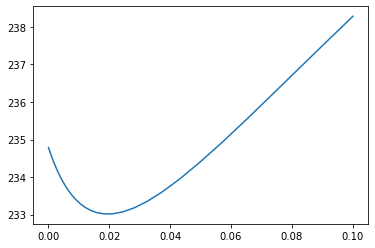

In [19]:
plt.plot(lambda_list,nll_list)

In [25]:
min_nll = min(nll_list)
min_index = nll_list.index(min_nll)
min_lambda = lambda_list[min_index]
print("Min NLL:",min_nll,"Lambda:",min_lambda)

Min NLL: 233.0183069467581 Lambda: 0.018420699693267165


## Minimum NLL achieved at $\lambda = 0.01842$, with $NLL = 233$

### Problem 8

In [21]:
#Use the Optimal Theta Calculated in the Last Problem
optimal_theta = fit_logistic_reg(X_train,y_train,f_objective,l2_param=min_lambda)

In [22]:
#Initialize helper variable
scores = []
#Calculate a score for each observation in X_val
for i in range(len(X_val)):
    score = 1 / (1 + np.exp(-optimal_theta@X_val[i,:]))
    scores.append(score)

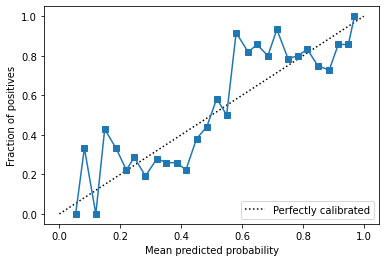

In [23]:
#Use Sci-Kit Learn Template to Show how Calibrated Our Model is
from sklearn.calibration import calibration_curve, CalibrationDisplay
y_true, y_prob = y_val, scores

prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=30)
disp = CalibrationDisplay(prob_true, prob_pred,y_prob)
disp.plot()

Text(0, 0.5, 'Count')

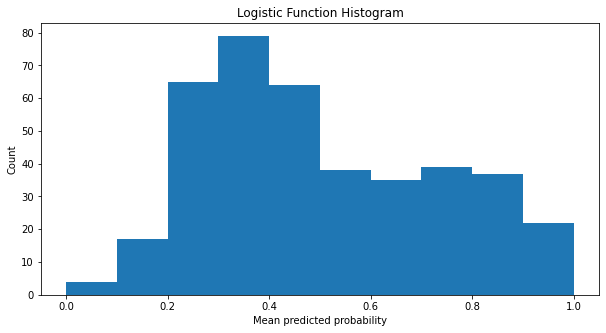

In [24]:
plt.figure(figsize=(10,5))
plt.hist(disp.y_prob, range=(0,1), bins=10, histtype='bar')
plt.title('Logistic Function Histogram')
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")

## Commentary:
It appears that our model is not very well calibrated: 